## Process z-score, eval score, Generate Tables and Images.

Before running this notebook, please run the following scripts:
``` bash   
    python -m process.process_z --model llama2-7b-chat-4k
    python -m process.process_z --model internlm-7b-8k
```

In [ ]:

import json
import re
import os
import pandas as pd

# Record the eval score for different models, modes and missions
df_eval = pd.DataFrame(columns=["model_name", "mode", "mission_name", "score"])
# Record the TP score for different models, modes and missions
df_tp = pd.DataFrame(columns=["model_name", "mode", "mission_name", "z_score", "true_positive", "sum"])
# Record the TN score for different models, modes and missions
df_tn = pd.DataFrame(columns=["model_name", "mode", "mission_name", "true_negative"])
tn_dict = [{} for i in range(5)]
eval_dict = [{} for i in range(5)]

save_csv_dir = "csv_data"

if not os.path.exists(save_csv_dir):
    os.makedirs(save_csv_dir)
    
save_pic_dir = "pictures"

if not os.path.exists(save_pic_dir):
    os.makedirs(save_pic_dir)

input_dir = "./pred"

flag = 1 # 0: internlm 0.95TP 1: llama 0.95TP 2: llama 0.7TP
model_names = ["internlm-7b-8k", "llama2-7b-chat-4k", "llama2-7b-chat-4k"]

modes0 = ["internlm-7b-8k_no_g0.1_d10.0", "llama2-7b-chat-4k_no_g0.5_d5.0", "llama2-7b-chat-4k_no_g0.5_d5.0"]
modes1 = ["internlm-7b-8k_old_hard_g0.15_d10.0", "llama2-7b-chat-4k_old_hard_g0.25_d5.0", "llama2-7b-chat-4k_old_hard_g0.75_d5.0"]
modes2 = ["internlm-7b-8k_old_soft_g0.1_d10.0", "llama2-7b-chat-4k_old_soft_g0.1_d10.0", "llama2-7b-chat-4k_old_soft_g0.75_d15.0"]
modes3 = ["internlm-7b-8k_gpt_g0.25_d15.0", "llama2-7b-chat-4k_gpt_g0.1_d10.0", "llama2-7b-chat-4k_gpt_g0.65_d12.5"]
modes4 = ["internlm-7b-8k_v2_g0.1_d10.0", "llama2-7b-chat-4k_v2_g0.25_d15.0", "llama2-7b-chat-4k_v2_g0.75_d15.0"]

all_modes = [modes0, modes1, modes2, modes3, modes4]

# All missions
dict_mission = {
    0: "konwledge_memorization",
    1: "konwledge_understanding",
    2: "longform_qa",
    3: "finance_qa",
    4: "hotpotqa",
    5: "lcc",
    6: "multi_news",
    7: "qmsum",
    8: "alpacafarm",
    9: "avarage_mode"
}

# All missions Categories
dict_cate_mission = {
    0: "C1:(Short Q, Short A)",
    1: "C2:(Short Q, Long A)",
    2: "C3:(Long Q, Short A)",
    3: "C4:(Long Q, Long A)",
    4: "C5:Open-Ended",
    5: "C6:OverAll"
}
  
model_name = model_names[flag]
modes = [modes_i[flag] for modes_i in all_modes]

tn_detect_modes = ["_".join(modex.split("_")[1:]) for modex in modes]
# print(tn_detect_modes)

num_eval = 0
num_z = 0
p = r"(?P<model_name>.+)_(?P<mode>old|v2|gpt|new|no)_g(?P<gamma>.+)_d(?P<delta>\d+(\.\d+)?)"
p_z = r"(?P<mission_name>[a-zA-Z_]+)_(?P<gamma>\d+(\.\d+)?)_(?P<delta>.+)_z"
p_mutual_z = r"(?P<mission_name>[a-zA-Z_]+)_(?P<threshold>\d+(\.\d+)?)_z"

### Calculate TP and Eval score for every group experiment

In [ ]:
# get all files from input_dir
for subfolder in os.listdir(input_dir):
    
    if "human" in subfolder:
        continue
    matcher = re.match(p, subfolder)
    
    model_name_now = matcher.group("model_name")
    if model_name_now != model_name:
        continue
    print("subfolder is:", subfolder)
    mode = matcher.group("mode")
    gamma = matcher.group("gamma")
    delta = matcher.group("delta")
    
    bl_type = "None"
    bl_type = (subfolder.split("_")[-1]).split(".")[0]
    
    if bl_type != "hard":
        if "old" in subfolder:
            bl_type = "soft"
        else:
            bl_type = "None"
        
    if bl_type == "hard" or bl_type == "soft":
        final_mode = model_name + "_" + mode + "_" + bl_type + "_" + "g"+gamma + "_" + "d" + delta  
    else:
        final_mode = model_name + "_" + mode + "_" + "g"+gamma + "_" + "d" + delta 
        
    eval_path = os.path.join(input_dir, subfolder, "eval")
    z_score_path = os.path.join(input_dir, subfolder, "z_score")
    threshold = 4.0
    if os.path.exists(z_score_path):
        temp_df = pd.DataFrame(columns=["model_name", "mode", "mission_name", "z_score", "true_positive", "sum"])
        all_z = []
        all_sum = []
        all_tp = 0
        
        
        files = os.listdir(z_score_path)
        for file in files:
            tp = 0
            matcher1 = re.match(p_z, file)
            
            if matcher1:
                mission_name = matcher1.group("mission_name")
            
            with open(os.path.join(z_score_path, file), "r") as f:
                data = json.load(f) 
                
            z_score_list = data["z_score_list"]
            _sum = len(data["z_score_list"])   
            tp += len([x for x in z_score_list if x > threshold])
            avarage_z = data["avarage_z"]
            temp = pd.DataFrame({
                "model_name": [model_name],
                "mode": [final_mode],
                "mission_name": [mission_name],
                "z_score": [avarage_z],
                "true_positive": [tp/_sum],
                "sum": [_sum]})
            
            df_tp = pd.concat([df_tp, temp], ignore_index=True)
            all_z.append(avarage_z * _sum)
            all_sum.append(_sum)
            all_tp += tp
            num_z += 1
            
        temp_df = pd.DataFrame({
            "model_name": [model_name],
            "mode": [final_mode],
            "mission_name": ["avarage_mode"],
            "z_score": [sum(all_z) / sum(all_sum)],
            "true_positive": [all_tp/sum(all_sum)], 
            "sum": [all_sum]
        })
        df_tp = pd.concat([df_tp, temp_df], ignore_index=True)   
         
    if os.path.exists(eval_path):
        result_file = os.path.join(eval_path, "result.json")
        if os.path.exists(result_file):
            with open (result_file, "r") as f:
                data = json.load(f)
            keys = data.keys()
            temp_df = pd.DataFrame(columns=["model_name", "mode", "mission_name", "score"])
            all_scores = []
            for key in keys:
                eval_score = float((str(data[key])).split(" ")[-1])
                temp_df = pd.DataFrame({
                    "model_name":[model_name],
                    "mode":[final_mode],
                    "mission_name": [key],
                    "score":[eval_score]
                })
                
                all_scores.append(eval_score)
                df_eval = pd.concat([df_eval, temp_df], ignore_index=True)
                
                num_eval += 1
                
            temp_df = pd.DataFrame({
                    "model_name":[model_name],
                    "mode":[final_mode],
                    "mission_name": ["avarage_mode"],
                    "score":[sum(all_scores) / len(keys)]
                })   
            
            df_eval = pd.concat([df_eval, temp_df], ignore_index=True) 
            

### Record the results in the csv file

In [ ]:
df_tp.to_csv(os.path.join(save_csv_dir, f"z_score_tp_{model_name}.csv"))           
# print(df_tp)
# print(num_z)

df_eval = df_eval.sort_values(by="mode", ascending=True)                 
df_eval.to_csv(os.path.join(save_csv_dir, f"eval_{model_name}.csv"))                
# print("num is:", num_eval)

### Calculate and Record TN

In [ ]:
input_dir = f"./detect_human/{model_name}/"

df_human = pd.DataFrame(columns=["model_name", "mission_name", "ref_mode", "det_mode", "threshold", "z_score", "true_negative", "sum", "tn_num"])

num = 0
for subfolder in os.listdir(input_dir):
    ref_mode = "_".join(subfolder.split("_")[1:])
    # print("ref_mode is", ref_mode)
    if ref_mode in tn_detect_modes:
        # print("mode_des is", ref_mode)
        
        for subsubfolder in os.listdir(os.path.join(input_dir,subfolder)):
            det_mode = subsubfolder.split("_z")[0]
            print(det_mode)
            
            z_score_path = os.path.join(input_dir, subfolder, subsubfolder)
            if os.path.exists(z_score_path):
                files = os.listdir(z_score_path)
                
                all_z = []
                all_sum = []
                all_tn = 0
                
                for file in files:
                    tn = 0
                    matcher2 = re.match(p_mutual_z, file)
                    if matcher2:
                        mission_name = matcher2.group("mission_name")
                        threshold = float(matcher2.group("threshold"))
                        
                    with open(os.path.join(z_score_path, file), "r") as f:
                        data = json.load(f)
                        
                        
                    avarage_z = data["avarage_z"]
                    z_score_list = data["z_score_list"]
                    _sum = len(data["z_score_list"])
                    
                    tn += len([x for x in z_score_list if x <= threshold])
                    num += 1
                    
                    temp_df = pd.DataFrame({
                        "model_name": [model_name],
                        "ref_mode": [ref_mode],
                        "mission_name": [mission_name],
                        "det_mode":[det_mode],
                        "threshold": [threshold],
                        "z_score": [avarage_z],
                        "true_negative": [tn/_sum],
                        "tn_num": [tn],
                        "sum": [_sum]
                    })
                    all_tn += tn
                    all_z.append(avarage_z * _sum)
                    all_sum.append(_sum)
                    
                    df_human = pd.concat([df_human, temp_df], ignore_index=True)
                temp_df = pd.DataFrame({
                        "model_name": [model_name],
                        "ref_mode": [ref_mode],
                        "mission_name": ["avarage_mode"],
                        "det_mode":[det_mode],
                        "threshold": [threshold],
                        "z_score": [sum(all_z) / sum(all_sum)],
                        "true_negative": [all_tn/sum(all_sum)],
                        "tn_num": [all_tn],
                        "sum": [sum(all_sum)]
                    })
                
                df_human = pd.concat([df_human, temp_df], ignore_index=True)
                    
df_human.to_csv(os.path.join(save_csv_dir, f"human_z_tn_{model_name}.csv"))

### Obtain TN

In [ ]:
df_tn = pd.read_csv(f"{save_csv_dir}/human_z_tn_{model_name}.csv")

# print(df_tn)

### Table 3 & Table 5 C1, C2, C3(Latex Format)

In [ ]:
output_str = model_name
if "llama" in model_name:
    output_str = "Llama2-7B-chat"
elif "internlm" in model_name:
    output_str = "Internlm-7B-8k"    

eval_no = [0 for i in range(6)]

for j in range(len(tn_detect_modes)):
    
    for i in range(0, 6, 2):
        # Get tp scores
        output_str += " & "
        
        cond1 = (df_tp["mode"].str.contains(tn_detect_modes[j])) & (df_tp["mission_name"] == dict_mission[i])
        tp_score1 = df_tp.loc[cond1, "true_positive"]
        sum1 = df_tp.loc[cond1, "sum"]
        
        cond2 = (df_tp["mode"].str.contains(tn_detect_modes[j])) & (df_tp["mission_name"] == dict_mission[i + 1])
        tp_score2 = df_tp.loc[cond2, "true_positive"]
        sum2 = df_tp.loc[cond2, "sum"]
        
        if tp_score1.empty or tp_score2.empty or j == 0:
            output_str += "--"
        else:
            tp_score_i = float(tp_score1.iloc[0])
            tp_score_i1 = float(tp_score2.iloc[0])
            
            tp_score = (tp_score_i * int(sum1.iloc[0]) + tp_score_i1 * int(sum2.iloc[0])) / (int(sum1.iloc[0]) + int(sum2.iloc[0]))
            
            print("tp_score is", tp_score)
            output_str += str(round(float(tp_score) * 100, 1))

        # Get tn scores
        output_str += " & "
        cond1 = (df_tn["ref_mode"].str.contains(tn_detect_modes[j])) & (df_tn["mission_name"] == dict_mission[i])
        tn_num1 = df_tn.loc[cond1, "tn_num"]
        sum1 = df_tn.loc[cond1, "sum"]
        
        cond2 = (df_tn["ref_mode"].str.contains(tn_detect_modes[j])) & (df_tn["mission_name"] == dict_mission[i + 1])
        tn_num2 = df_tn.loc[cond2, "tn_num"]
        sum2 = df_tn.loc[cond2, "sum"]
        
        if tn_num1.empty or tn_num2.empty:
            output_str += "--" 
        else:
            tn_score = (int(tn_num1.iloc[0]) + int(tn_num2.iloc[0])) / (int(sum1.iloc[0]) + int(sum2.iloc[0]))
            
            tn_dict[j].update({f"{dict_cate_mission[i // 2]}":tn_score})
            
            print("tn_score is", tn_score)
            output_str += str(round(float(tn_score) * 100, 1))

        # Get eval scores
        output_str += " & "
        cond1 = (df_eval["mode"].str.contains(tn_detect_modes[j])) & (df_eval["mission_name"] == dict_mission[i])
        cond2 = (df_eval["mode"].str.contains(tn_detect_modes[j])) & (df_eval["mission_name"] == dict_mission[i + 1])
        eval_score1 = df_eval.loc[cond1, "score"]
        eval_score2 = df_eval.loc[cond2, "score"]
        if eval_score1.empty or eval_score2.empty:
            output_str += "--" 
        else:
            eval_score3 = (float(eval_score1.iloc[0]) + float(eval_score2.iloc[0])) / 2
            
            eval_dict[j].update({f"{dict_cate_mission[i // 2]}":eval_score3})
            print("eval_score is", eval_score3)
            output_str += str(round(eval_score3, 1))
        print("j =", j)    
        if j == 0:
            eval_no[i % 6] = float(eval_score3)
            print("eval_no is", eval_no)
            
        output_str += " & "
        if j != 0:
            print(f"eval_no[{i} % 6] is", eval_no[i % 6])
            print("eval_score3 is", eval_score3)
            down_rate = (eval_no[i % 6] - eval_score3) / eval_no[i % 6]
            down_rate = round((down_rate) * 100, 1)
            # if j == 1 and i == 0:
            output_str += f"$\\downarrow$ {down_rate}\\%"
            # else:
            #     output_str += f"{down_rate}"
        else:
            output_str += "--"    
    
    output_str += "\\\\\n"
    if j == 0:
        output_str += "+ hard watermark"
    if j == 1:
        output_str += "+ soft watermark"
    if j == 2:
        output_str += "+ gpt watermark"
    if j == 3:
        output_str += "+ v2 watermark"
        
print(output_str)

### Table 4 & Table 5 C4, C5, Overall(Latex Format)

In [ ]:
output_str = model_name
if "llama" in model_name:
    output_str = "Llama2-7B-chat"
elif "internlm" in model_name:
    output_str = "Internlm-7B-8k"    

# output_str = "Internlm-7B-8k"
eval_no = [0 for i in range(10)]

for j in range(len(tn_detect_modes)):
    
    i = 6
    # Get tp scores
    output_str += " & "
    
    cond1 = (df_tp["mode"].str.contains(tn_detect_modes[j])) & (df_tp["mission_name"] == dict_mission[i])
    tp_score1 = df_tp.loc[cond1, "true_positive"]
    sum1 = df_tp.loc[cond1, "sum"]
    
    cond2 = (df_tp["mode"].str.contains(tn_detect_modes[j])) & (df_tp["mission_name"] == dict_mission[i + 1])
    tp_score2 = df_tp.loc[cond2, "true_positive"]
    sum2 = df_tp.loc[cond2, "sum"]
    
    # tp_score_L1 = (tp_score1 * sum1 + tp_score2 *sum2) / (sum1 + sum2)
    
    if tp_score1.empty or tp_score2.empty or j == 0:
        output_str += "--"
    else:
        tp_score_i = float(tp_score1.iloc[0])
        tp_score_i1 = float(tp_score2.iloc[0])
        
        tp_score = (tp_score_i * int(sum1.iloc[0]) + tp_score_i1 * int(sum2.iloc[0])) / (int(sum1.iloc[0]) + int(sum2.iloc[0]))
        
        print("tp_score is", tp_score)
        output_str += str(round(float(tp_score) * 100, 1))

    # Get tn scores
    output_str += " & "
    cond1 = (df_tn["ref_mode"].str.contains(tn_detect_modes[j])) & (df_tn["mission_name"] == dict_mission[i])
    tn_num1 = df_tn.loc[cond1, "tn_num"]
    sum1 = df_tn.loc[cond1, "sum"]
    
    cond2 = (df_tn["ref_mode"].str.contains(tn_detect_modes[j])) & (df_tn["mission_name"] == dict_mission[i + 1])
    tn_num2 = df_tn.loc[cond2, "tn_num"]
    sum2 = df_tn.loc[cond2, "sum"]
    
    if tn_num1.empty or tn_num2.empty:
        output_str += "--" 
    else:
        tn_score = (int(tn_num1.iloc[0]) + int(tn_num2.iloc[0])) / (int(sum1.iloc[0]) + int(sum2.iloc[0]))
        
        tn_dict[j].update({f"{dict_cate_mission[i // 2]}":tn_score})
        print("tn_score is", tn_score)
        output_str += str(round(float(tn_score) * 100, 1))

    # Get eval scores
    output_str += " & "
    cond1 = (df_eval["mode"].str.contains(tn_detect_modes[j])) & (df_eval["mission_name"] == dict_mission[i])
    cond2 = (df_eval["mode"].str.contains(tn_detect_modes[j])) & (df_eval["mission_name"] == dict_mission[i + 1])
    eval_score1 = df_eval.loc[cond1, "score"]
    eval_score2 = df_eval.loc[cond2, "score"]
    if eval_score1.empty or eval_score2.empty:
        output_str += "--" 
    else:
        eval_score3 = (float(eval_score1.iloc[0]) + float(eval_score2.iloc[0])) / 2
        
        eval_dict[j].update({f"{dict_cate_mission[i // 2]}":eval_score3})
        print("eval_score is", eval_score3)
        output_str += str(round(eval_score3, 1))
    print("j =", j)    
    if j == 0:
        eval_no[i % 10] = float(eval_score3)
        print("eval_no is", eval_no)
        
    output_str += " & "
    if j != 0:
        print(f"eval_no[{i} % 10] is", eval_no[i % 10])
        print("eval_score3 is", eval_score3)
        down_rate = (eval_no[i % 10] - eval_score3) / eval_no[i % 10]
        down_rate = round((down_rate) * 100, 1)
        
        output_str += f"$\\downarrow$ {down_rate}\\%"
        
    else:
        output_str += "--"   
    
    # C5 & Overall
    for i in range(8, 10):
        # Get tp scores
        output_str += " & "
        tp_score = df_tp.loc[(df_tp["mode"].str.contains(tn_detect_modes[j])) & (df_tp["mission_name"] == dict_mission[i]), "true_positive"]
        if tp_score.empty or float(tp_score.iloc[0]) < 0.05:
            output_str += "--"
        else:
            tp_score = tp_score.iloc[0]
            print("tp_score is", tp_score)
            output_str += str(round(float(tp_score) * 100, 1))
    
        # Get tn scores
        output_str += " & "
        tn_score = df_tn.loc[(df_tn["ref_mode"].str.contains(tn_detect_modes[j])) & (df_tn["mission_name"] == dict_mission[i]), "true_negative"]
        if tn_score.empty:
            output_str += "--" 
        else:
            tn_score = tn_score.iloc[0]
            if i % 2 == 0:
                tn_dict[j].update({f"{dict_cate_mission[i // 2]}":tn_score})
            else:
                tn_dict[j].update({f"{dict_cate_mission[i // 2 + 1]}":tn_score})
            print("tn_score is", tn_score)
            output_str += str(round(float(tn_score) * 100, 1))

        # Get eval scores
        output_str += " & "
        eval_score = df_eval.loc[(df_eval["mode"].str.contains(tn_detect_modes[j])) & (df_eval["mission_name"] == dict_mission[i]), "score"]
        if eval_score.empty:
            output_str += "--" 
        else:
            eval_score = eval_score.iloc[0]
            if i % 2 == 0:
                eval_dict[j].update({f"{dict_cate_mission[i // 2]}":eval_score})
            else:
                eval_dict[j].update({f"{dict_cate_mission[i // 2 + 1]}":eval_score})
            print("eval_score is", eval_score)
            output_str += str(round(float(eval_score), 1))  
            
        if j == 0:
            eval_no[i % 10] = float(eval_score)
            print("eval_no is", eval_no)
            
        output_str += " & "
        if j != 0:
            print(f"eval_no[{i} % 10] is", eval_no[i % 10])
            print("eval_score3 is", eval_score)
            down_rate = (eval_no[i % 10] - eval_score) / eval_no[i % 10]
            down_rate = round((down_rate) * 100, 1)
            output_str += f"$\\downarrow$ {down_rate}\\%"
        else:
            output_str += "--" 
     
    
    output_str += "\\\\\n"
    if j == 0:
        output_str += "+ hard watermark"
    if j == 1:
        output_str += "+ soft watermark"
    if j == 2:
        output_str += "+ gpt watermark"
    if j == 3:
        output_str += "+ v2 watermark"
        
print(output_str)

### Appendix B Table 7(C1, C2 Full Results + Latex Format) 

In [ ]:
output_str = model_name
if "llama" in model_name:
    output_str = "Llama2-7B-chat"
elif "internlm" in model_name:
    output_str = "Internlm-7B-8k"    

for j in range(len(tn_detect_modes)):
    for i in range(4):
        
        # Get tp scores 
        output_str += " & "
        tp_score = df_tp.loc[(df_tp["mode"].str.contains(tn_detect_modes[j])) & (df_tp["mission_name"] == dict_mission[i]), "true_positive"]
        if tp_score.empty or float(tp_score.iloc[0]) < 0.05 or j == 0:
            output_str += "--"
        else:
            tp_score = tp_score.iloc[0]
            print("tp_score is", tp_score)
            output_str += str(round(float(tp_score) * 100, 1))
    
        # Get tn scores
        output_str += " & "
        tn_score = df_tn.loc[(df_tn["ref_mode"].str.contains(tn_detect_modes[j])) & (df_tn["mission_name"] == dict_mission[i]), "true_negative"]
        if tn_score.empty:
            output_str += "--" 
        else:
            tn_score = tn_score.iloc[0]
            print("tn_score is", tn_score)
            output_str += str(round(float(tn_score) * 100, 1))
    
        # Get eval scores
        output_str += " & "
        eval_score = df_eval.loc[(df_eval["mode"].str.contains(tn_detect_modes[j])) & (df_eval["mission_name"] == dict_mission[i]), "score"]
        if eval_score.empty:
            output_str += "--" 
        else:
            eval_score = eval_score.iloc[0]
            print("eval_score is", eval_score)
            output_str += str(round(float(eval_score), 1))
    
    output_str += "\\\\\n"
    if j == 0:
        output_str += "+ hard watermark"
    if j == 1:
        output_str += "+ soft watermark"
    if j == 2:
        output_str += "+ gpt watermark"
    if j == 3:
        output_str += "+ v2 watermark"
        
print(output_str)
    

 ### Appendix B Table 8(C3, C4 Full Results + Latex Format) 

In [ ]:
output_str = model_name
if "llama" in model_name:
    output_str = "Llama2-7B-chat"
elif "internlm" in model_name:
    output_str = "Internlm-7B-8k"    


for j in range(len(tn_detect_modes)):
    for i in range(4, 8):
    
        # Get tp scores    
        output_str += " & "
        tp_score = df_tp.loc[(df_tp["mode"].str.contains(tn_detect_modes[j])) & (df_tp["mission_name"] == dict_mission[i]), "true_positive"]
        if tp_score.empty or float(tp_score.iloc[0]) < 0.05 or j == 0:
            output_str += "--"
        else:
            tp_score = tp_score.iloc[0]
            print("tp_score is", tp_score)
            output_str += str(round(float(tp_score) * 100, 1))
    
        # Get tn scores
        output_str += " & "
        tn_score = df_tn.loc[(df_tn["ref_mode"].str.contains(tn_detect_modes[j])) & (df_tn["mission_name"] == dict_mission[i]), "true_negative"]
        if tn_score.empty:
            output_str += "--" 
        else:
            tn_score = tn_score.iloc[0]
            print("tn_score is", tn_score)
            output_str += str(round(float(tn_score) * 100, 1))
    
        # Get eval scores
        output_str += " & "
        eval_score = df_eval.loc[(df_eval["mode"].str.contains(tn_detect_modes[j])) & (df_eval["mission_name"] == dict_mission[i]), "score"]
        if eval_score.empty:
            output_str += "--" 
        else:
            eval_score = eval_score.iloc[0]
            print("eval_score is", eval_score)
            output_str += str(round(float(eval_score), 1))
    
    output_str += "\\\\\n"
    if j == 0:
        output_str += "+ hard watermark"
    if j == 1:
        output_str += "+ soft watermark"
    if j == 2:
        output_str += "+ gpt watermark"
    if j == 3:
        output_str += "+ v2 watermark"
        
print(output_str)

 ### Appendix B Table 9(C5, Overall Full Results + Latex Format) 

In [ ]:
output_str = model_name
if "llama" in model_name:
    output_str = "Llama2-7B-chat"
elif "internlm" in model_name:
    output_str = "Internlm-7B-8k"    


for j in range(len(tn_detect_modes)):
    for i in range(8, 10):
        
        # Get tp scores
        output_str += " & "
        tp_score = df_tp.loc[(df_tp["mode"].str.contains(tn_detect_modes[j])) & (df_tp["mission_name"] == dict_mission[i]), "true_positive"]
        if tp_score.empty or float(tp_score.iloc[0]) < 0.05 or j == 0:
            output_str += "--"
        else:
            tp_score = tp_score.iloc[0]
            print("tp_score is", tp_score)
            output_str += str(round(float(tp_score) * 100, 1))
    
        # Get tn scores
        output_str += " & "
        tn_score = df_tn.loc[(df_tn["ref_mode"].str.contains(tn_detect_modes[j])) & (df_tn["mission_name"] == dict_mission[i]), "true_negative"]
        if tn_score.empty:
            output_str += "--" 
        else:
            tn_score = tn_score.iloc[0]
            print("tn_score is", tn_score)
            output_str += str(round(float(tn_score) * 100, 1))
    
        # Get eval scores
        output_str += " & "
        eval_score = df_eval.loc[(df_eval["mode"].str.contains(tn_detect_modes[j])) & (df_eval["mission_name"] == dict_mission[i]), "score"]
        if eval_score.empty:
            output_str += "--" 
        else:
            eval_score = eval_score.iloc[0]
            print("eval_score is", eval_score)
            output_str += str(round(float(eval_score), 1))
    
    output_str += "\\\\\n"
    if j == 0:
        output_str += "+ hard"
    if j == 1:
        output_str += "+ soft"
    if j == 2:
        output_str += "+ gpt"
    if j == 3:
        output_str += "+ v2"
        
print(output_str)

### Hyper-parameters Search(Figure 3)

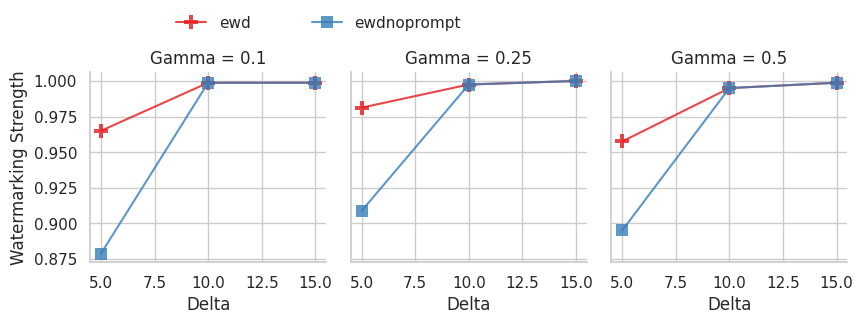

In [3]:
from turtle import title
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
def combine_mode_bl_type (x):
  if pd.isnull (x ['bl_type']):
    return x['mode']
  else:
    return x ['mode']+"_"+x['bl_type']

df_avg = pd.read_csv(f"/cluster/tufts/laolab/kdoan02/WaterBench/process/csv_data2/z_score_avg_llama2_ewd_with_prompt.csv")
sns.set_theme(style="whitegrid")
rs = np.random.RandomState(5)
df_clean = df_avg.drop(df_avg[(df_avg["mode"] == "new") | (df_avg["mode"] == "no") | (df_avg["gamma"] == 0.65) | (df_avg["gamma"] == 0.2)| (df_avg["gamma"] == 0.7)    | (df_avg["gamma"] == 0.6) | (df_avg["delta"] == 9.0)].index)
df_clean['watermark type'] = df_clean.apply(combine_mode_bl_type, axis=1)
df_clean = df_clean.replace("ogv2", "SelfHash")
df_clean = df_clean.replace("v2", "LeftHash")
df_clean = df_clean.replace("gpt", "Unigram")
df_clean = df_clean.replace("old_hard", "Hard")

df_clean = df_clean.replace("onebitsparse_hard", "Sparse (Hard)")
df_clean = df_clean.replace("onebitsparse_soft", "Sparse (Soft)")


g = sns.FacetGrid(df_clean, col="gamma", hue="watermark type", palette="Set1", hue_kws={"marker": ["P", "s", "^", "v","<",">","*"], "markersize": [10, 8, 8, 8, 8, 8, 8], "markeredgewidth": [0, 0, 0, 0, 0, 0, 0], "alpha": [0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8]})

g.map(sns.lineplot, "delta", "true_positive", marker=True, dashes=False)

g.set_axis_labels("Delta", "Watermarking Strength")
g.set_titles("Gamma = {col_name}")

g.add_legend(title="", loc="upper center", ncol=5, bbox_to_anchor=(0.3, 1.1), columnspacing=4.0)

# plt.savefig(f"{save_pic_dir}/{model_name}_search.pdf", dpi=400, bbox_inches='tight')
plt.show()
g.savefig("hyper_parameter.pdf", bbox_inches='tight')


### TN and GM Results(Figure 4)

In [ ]:
# coding=utf-8
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

print(tn_dict)
print(eval_dict)


scores_mode = ["no", "hard", "soft", "gpt", "v2"]
colors = ['b', 'g', 'r', 'y', 'c', 'm', 'k']

new_mode_tn_dict = {}
for index, t in enumerate(tn_dict):
    if t:
        new_mode_tn_dict.update({scores_mode[index]:t})
        
new_mode_tn_list = list(new_mode_tn_dict.items())

plt.style.use('seaborn')

def draw(ax, start_point, end_point, para_dict, title):
    
    new_mode_para_dict = {}
    for index, t in enumerate(para_dict[1:]):
        new_mode_para_dict.update({scores_mode[index]:t})
        
    new_mode_para_list = list(new_mode_para_dict.items())
    data_length = len(new_mode_para_list[0][1].values())
    print("data_length is", data_length)
    
    angles = np.linspace(0, 2*np.pi, data_length, endpoint=False)
    print(new_mode_para_list[0][1].values())
    print(new_mode_para_list[0][0])
    labels = [key for key in new_mode_para_list[0][1].keys()]
    print("labels is", labels)
    score = [list(result[1].values()) for result in new_mode_para_list]
    
    print("score is", score)
    
    scores = []
    patches = []
    for i in range(len(score)):
        score_i = np.concatenate((score[i], [score[i][0]]))
        scores.append(score_i)
        
    angles = np.concatenate((angles, [angles[0]]))
    labels = np.concatenate((labels, [labels[0]]))
    
    for index, score_i in enumerate(scores):
        patch = mpatches.Patch(color=colors[index], label=list(new_mode_tn_dict.keys())[index].split("_")[-1])
        patches.append(patch)
        ax.plot(angles, score_i, color=colors[index])
        ax.fill(angles, score_i, alpha=0.25)
    
    ax.set_thetagrids(angles*180/np.pi, labels)
    
    ax.set_theta_zero_location('N')
    
    # Set the range of polar axis
    ax.set_rlim(start_point, end_point)
    ax.tick_params(axis='y', labelsize=8, labelcolor='gray')
    
    ax.set_rlabel_position(0)
    ax.set_title(title, fontweight='bold', x=-0.25, y=1, fontsize=16)
    
    # Adjust Label Positiona
    for label in ax.get_xticklabels():
        label_text = label.get_text()
        if "C1" in label_text or "C4" in label_text:
            label.set_position((label.get_position()[0], -0.05))
        else:
            label.set_position((label.get_position()[0], -0.2))
            
    return patches

fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw=dict(polar=True),  figsize=(16, 4))

if "llama" in model_name:
    patches = draw(ax1, 0.8, 1, tn_dict, "True Negative") 
elif "internlm" in model_name:
    patches = draw(ax1, 0.9, 1, tn_dict, "True Negative")    

patches = draw(ax2, 0, 20, eval_dict, "Generation Metric")  

plt.subplots_adjust(wspace=0)
    
lgd=fig.legend(handles=patches, loc='lower center', ncols=4, bbox_to_anchor=(0.5,-0.05), prop={'size': 12})

my_suptitle=fig.suptitle(f'{model_name}', x=0.475, y=1.1, fontweight='bold', fontsize=18)

plt.subplots_adjust(wspace=0.25)

# plt.savefig(f"{save_pic_dir}/{model_name}_radar.pdf", dpi=100, bbox_inches='tight', bbox_extra_artists=(my_suptitle, lgd))

# plt.savefig(f"{save_pic_dir}/{model_name}_radar.png", dpi=100, bbox_inches='tight', bbox_extra_artists=(my_suptitle, lgd))


plt.show()   

### Prepare GM scores and WaterMark classes for Figure 6

In [ ]:
# Read eval_{model_name}.csv
df_eval_llama = pd.read_csv(f"{save_csv_dir}/eval_llama2-7b-chat-4k.csv")
df_eval_internlm = pd.read_csv(f"{save_csv_dir}/eval_internlm-7b-8k.csv") 
df_eval_all = pd.concat([df_eval_llama.iloc[:, 1:], df_eval_internlm.iloc[:, 1:]], axis=0, ignore_index=True)

print(df_eval_all)
df_eval_all.to_csv(f"{save_csv_dir}/eval_all.csv")

id2dataset = {
    '1-1': 'konwledge_memorization',
    '1-2': 'konwledge_understanding',
    '2-1': 'longform_qa',
    '2-2': 'finance_qa',
    '3-1': 'hotpotqa',
    '3-2': 'lcc',
    '4-1': 'multi_news',
    '4-2': 'qmsum',
    '5-1': 'alpacafarm'
}

# All the conditions under 0.95TP
process_modes = {'internlm': modes0[0],
                 'internlm_hard': modes1[0],
                 'internlm_soft': modes2[0],
                 'internlm_gpt': modes3[0],
                 'internlm_v2': modes4[0],
                 'llama2': modes0[1],
                 'llama2_hard': modes1[1],
                 'llama2_soft': modes2[1],
                 'llama2_gpt': modes3[1],
                 'llama2_v2': modes4[1]}
all_eval_modes = []
for i in range(len(all_modes[0])):
    for j in range(len(all_modes)):
        all_eval_modes.append(all_modes[j][i])

print(all_eval_modes)


In [ ]:
draw_matrix = pd.DataFrame(index=id2dataset.keys(), columns=process_modes.keys())
for index, row in draw_matrix.iterrows():
    for process_mode in process_modes.keys():
        score = df_eval_all[(df_eval_all['mission_name'] == 
                             id2dataset.get(index)) & 
                            (df_eval_all['mode'] == process_modes.get(process_mode))]['score']
        draw_matrix.loc[index, process_mode] = score.values[0]
        
print(draw_matrix)
draw_matrix.to_csv(f"{save_csv_dir}/heatmap.csv")


# print(draw_matrix.columns)
# print(draw_matrix.index)
draw_matrix.index.name = "Unnamed: 0"
draw_matrix1 = pd.read_csv(f"{save_csv_dir}/heatmap.csv")

# Set the first column as index
draw_matrix1.set_index('Unnamed: 0', inplace=True)
draw_matrix1.index.name = None
draw_matrix1.columns.name = None
print(draw_matrix1.columns)
print(draw_matrix1.index)

### Spearman Correlation for GM between each pair of task in WaterBench(Figure 6)

In [ ]:
spr_scores = draw_matrix1.transpose().corr(method='spearman').round(2)
fig, ax = plt.subplots(figsize=(20,15))
colormap = sns.cubehelix_palette(start=2.8, rot=0.1, gamma=0.2, dark=-0.0, light=0.95, as_cmap=True)
hs = sns.heatmap(spr_scores, vmin=-1, vmax=1, annot=True, annot_kws={'size':36}, cmap=colormap, cbar_kws={"pad":0.02})
cbar = ax.collections[0].colorbar
# here set the labelsize by 20
cbar.ax.tick_params(labelsize=36)

# ax.set_title('Spearman\'s ρ between datasets with model performance as variables', fontsize=20)
ax.tick_params(labelsize=36, rotation=30)

y_colors=['blue']*2 + ['green']*2 + ['orange']*2 + ['red']*2 + ['black']*1
x_colors=['blue']*5 + ['green']*5
[t.set_color(y_colors[i]) for i,t in enumerate(ax.xaxis.get_ticklabels())]
[t.set_color(y_colors[i]) for i,t in enumerate(ax.yaxis.get_ticklabels())]
plt.tight_layout()
# fig.savefig(f'{save_pic_dir}/heat_datasets.pdf')
plt.show()
# fig.savefig(f'{save_pic_dir}/heat_datasets.pdf')

### Scatter plots for each pair of tasks(Figure 5)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib import gridspec
import numpy as np
import scipy
from scipy.interpolate import make_interp_spline

In [ ]:
def display_scatter_multilines(Xs, Ys, names=None, xlabels=None, ylabels=None, xlim=None, ylim=None,
                               titles=None, save_name=None, fit='polyfit'):
    
    titles = titles if titles is not None else [""]*len(Xs)
    xlabels = xlabels if xlabels is not None else [""]*len(Xs)
    ylabels = ylabels if ylabels is not None else [""]*len(Xs)
    cols = 2
    rows = len(Xs) // 2
    fig, axes = plt.subplots(rows, cols, figsize=(20,15), tight_layout=True)
    if cols <= 1:
        axes = np.array([axes])
        
    for i, (X,Y) in enumerate(zip(Xs,Ys)):
        r, c = i // rows, i % rows
        title = titles[i] if titles is not None else None
        axes[r,c].set_title(title, fontsize=30)
        axes[r,c].set_xlabel(xlabels[i], fontsize=16)
        axes[r,c].set_ylabel(ylabels[i], fontsize=16)
        axes[r,c].xaxis.set_minor_locator(MultipleLocator(1))
        if xlim is not None: axes[r,c].set_xlim(xlim)
        if ylim is not None: axes[r,c].set_ylim(ylim)
#         axes[i].scatter(X, Y, s=25, c="#9370DB", alpha=0.5)
        axes[r,c].scatter(X, Y, c='gray', marker='o', edgecolors='k', s=40)
#         axes[i].set_yticks(np.unique(Y))
        # annotate points
        if names:
            for i in range(len(X)):
                plt.annotate(names[i], xy=(X[i],Y[i]), xytext=(X[i]-0.5,Y[i]+0.8), fontsize=6)
        axes[r,c].grid(alpha=0.2)
        axes[r,c].tick_params(labelsize=36)
        
        # Fit
        if fit != '':
            p = np.polyfit(X, Y, 1) # # p[0]=Gradient, p[1]=y-intercept
            model = np.poly1d(p)
            # Fit the model
            y_model = model(X)
            
            # Number of observations
            n = Y.size
            # Number of parameters: equal to the degree of the fitted polynomial (ie the
            # number of coefficients) plus 1 (ie the number of constants)
            m = p.size
            # Degrees of freedom (number of observations - number of parameters)
            dof = n - m
            # Significance level
            alpha = 0.05
            # We're using a two-sided test
            tails = 2
            # The percent-point function (aka the quantile function) of the t-distribution
            # gives you the critical t-value that must be met in order to get significance
            t_critical = scipy.stats.t.ppf(1 - (alpha / tails), dof)
            # Mean
            y_bar = np.mean(Y)
            # Coefficient of determination, R²
            R2 = np.sum((y_model - y_bar)**2) / np.sum((Y - y_bar)**2)
            
            # Calculate the residuals (the error in the data, according to the model)
            resid = Y - y_model
            # Chi-squared (estimates the error in data)
            chi2 = sum((resid / y_model)**2)
            # Reduced chi-squared (measures the goodness-of-fit)
            chi2_red = chi2 / dof
            # Standard deviation of the error
            std_err = np.sqrt(sum(resid**2) / dof)

            xlim = axes[r,c].get_xlim()
            ylim = axes[r,c].get_ylim()
            # Line of best fit
            axes[r,c].plot(np.array(xlim), p[1] + p[0] * np.array(xlim), label=f'Line of Best Fit, R² = {R2:.2f}')
            
            # Fit
            x_fitted = np.linspace(xlim[0], xlim[1], 300)
            y_fitted = np.polyval(p, x_fitted)
            # Confidence interval
            ci = t_critical * std_err * np.sqrt(1 / n + (x_fitted - np.mean(X))**2 / np.sum((X - np.mean(X))**2))
            axes[r,c].fill_between(
                x_fitted, y_fitted + ci, y_fitted - ci, facecolor='#b9cfe7', zorder=0,
                label=r'95% Confidence Interval'
            )
            axes[r,c].legend(fontsize=32, loc='upper left')
    
    # ax = plt.gca()
    # ax.set_yticks(Ys[0])
    plt.tight_layout()
    if save_name:
        fig.savefig(f"{save_pic_dir}/{save_name}", dpi=400)
    plt.show()

In [ ]:
draw_matrix_T = draw_matrix1.transpose()



Xs = [draw_matrix_T['1-1'], draw_matrix_T['2-1'], draw_matrix_T['3-1'], draw_matrix_T['4-1']]

Ys = [draw_matrix_T['1-2'], draw_matrix_T['2-2'], draw_matrix_T['3-2'], draw_matrix_T['4-2']]

# print(len(Ys))
# print(Ys)

display_scatter_multilines(Xs, Ys, titles=['category-1: Short Q, Short A', 'category-2: Short Q, Long A', 'category-3: Long Q, Short A', 'category-4: Long Q, Long A', 'category-5: Open-End'], save_name='scatters_all.pdf')

### Generate ROC Curve And Calculate AUC Values(Figure 7)

In [ ]:
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import numpy as np

# plt.rc('font',family='times')
plt.clf()
plt.figure(constrained_layout=True)
# plt.figure(figsize=(5, 4))
figure ,axes =plt.subplots(1,2,figsize=(14,6),dpi=400)
pred_dir = "./pred"

# Make colormap
viridis = plt.colormaps['viridis'].resampled(len(modes) + 1) 
cmap = viridis.colors[:(len(modes))][::-1]
mutual_dir = f"mutual_detect/{model_name}"

for flag in [1, 2]:
    tp_var = "0.95TP" if flag == 1 else "0.7TP"
    modes = [modes_i[flag] for modes_i in all_modes]
    for j in range(1, 5): # mode:0 1 2 3 4
        all_z_scores = []
        all_human_z_scores = []
        all_wm_z_scores = []
        
        # get as reference to detect human generation z_scores
        # print(modes[j])
        ref_substr = "_".join(modes[j].split("_")[1:])   
        # print(ref_substr) 
        ref_subfolder = "ref_" + ref_substr
        # print(ref_subfolder)
        human_z_path = os.path.join(ref_subfolder, "human_generation_z")
        human_z_path = os.path.join(mutual_dir, human_z_path)
        files = os.listdir(human_z_path)
        for file in files:
            with open(os.path.join(human_z_path, file), "r") as f:
                data = json.load(f) 
                
            z_score_list = data["z_score_list"]     
            # concatenate all_z_score and z_score_list
            all_z_scores.extend(z_score_list)
            all_human_z_scores.extend(z_score_list)
        wm_type = "hard" if "hard" in modes[j] else "soft"
            
        if "old_hard" in modes[j]:
            elem = modes[j].split("_")
            # print(elem)
            # print(elem[2])
            new_elem = elem[:]
            new_elem.pop(2)
            # print(elem)
            new_elem.append(elem[2])
            act_subfolder = "_".join(new_elem)
            
        elif "old_soft" in modes[j]:
            elem = modes[j].split("_")
            new_elem = elem
            new_elem.pop(2)
            act_subfolder = "_".join(new_elem)
        else:
            act_subfolder = modes[j]
            wm_type = modes[j].split("_")[1]
        
        filedir_path = os.path.join(pred_dir, act_subfolder)
        z_score_path = os.path.join(filedir_path, "z_score")
        
        # print("z_score_path", z_score_path)
        if os.path.exists(z_score_path):
            files = os.listdir(z_score_path)
            for file in files:
                with open(os.path.join(z_score_path, file), "r") as f:
                    data = json.load(f) 
                    
                z_score_list = data["z_score_list"]     
                # concatenate all_z_score and z_score_list
                all_z_scores.extend(z_score_list)
                all_wm_z_scores.extend(z_score_list)
                
        baseline_labels = np.zeros_like(all_human_z_scores)
        wm_labels = np.ones_like(all_wm_z_scores)
        all_labels = np.concatenate([baseline_labels, wm_labels])
        
        fpr, tpr, thresholds = metrics.roc_curve(all_labels, all_z_scores, pos_label=1)
        roc_auc = metrics.auc(fpr, tpr)
        model_name0 = modes[j].split("-")[0]
        
        axes[flag - 1].plot(fpr, tpr, color=cmap[j], label = f"{model_name0}_{wm_type},AUC:%0.3f" % roc_auc, linewidth=3)   
        
    axes[flag - 1].set_xlabel('False Positive Rate', fontsize = 12)
    axes[flag - 1].set_ylabel('True Positive Rate', fontsize = 12)
    axes[flag - 1].set_title(tp_var, fontsize=30)
    axes[flag - 1].plot([0, 1], [0, 1],'r--')
    axes[flag - 1].set_xlim([0, 1])
    axes[flag - 1].set_ylim([0, 1])
    axes[flag - 1].legend(loc = 'lower right', fontsize = 12)
    
plot_name = (f"roc_auc")

figure.savefig(f"{save_pic_dir}/{plot_name}.pdf", format="pdf")
# print(plot_name)

plt.show()